In [1]:
import numpy as np
import h5py
import scipy.signal
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2025-09-14 11:53:57.692653: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-14 11:53:57.703376: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-14 11:53:58.056873: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-14 11:53:59.506680: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [ ]:
class Hdf5DataGenerator:

    def __call__(self, filename, batchsize):
        
        # When using with tensorflow datasets, string args are passed as bytes.
        # Convert them back
        if isinstance(filename, bytes):
            filename = filename.decode()

        with h5py.File(filename, "r") as fin:

            waveforms = fin.get('waveforms')
            event_types = fin.get('type')
            p_start = fin.get('p_start')
            s_start = fin.get('s_start')

            waveform_length = waveforms[0].shape[0]
            istart = 0
            istop = batchsize
            exhausted = False

            pick_width = 100
            half_pick_width = pick_width // 2
            pick = scipy.signal.windows.gaussian(pick_width, 12)


            assert False, 'NORMALIZE

            while not exhausted:

                data = waveforms[istart:istop]
                targets = []

                # Create the target class waveforms 
                for i in range(batchsize):

                    p_true = np.zeros(shape=(waveform_length))
                    s_true = np.zeros(shape=(waveform_length))
                    n_true = np.ones(shape=(waveform_length))
    
                    # Insert pick 
                    p_pos = p_start[i]
                    p_true[p_pos - half_pick_width : p_pos + half_pick_width] = pick
    
                    s_pos = s_start[i]
                    s_true[s_pos - half_pick_width : s_pos + half_pick_width] = pick
    
                    n_true -= p_true
                    n_true -= s_true

                    targets.append(
                        np.dstack([p_true, s_true, n_true])
                    )

                yield (data, np.vstack(targets))

                istart += batchsize
                istop += batchsize

                if istop > len(waveforms):
                    exhausted = True

                

            

        

In [ ]:
gen = Hdf5DataGenerator()


for batch in gen('selected_events.h5', 1):

    batch_data = batch[0]
    batch_targets = batch[1]
    
    print('batch_data.shape:', batch_data.shape)
    print('batch_targets.shape:', batch_targets.shape)

    for i in range(batch_data.shape[0]):

        data = batch_data[i]
        targets = batch_targets[i]
        
        _, ax = plt.subplots(4, 1, sharex=True)
        xvals = np.arange(data.shape[0])
    
        ax[0].plot(xvals, data[:, 2])
        ax[1].plot(xvals, targets[:, 0])
        ax[2].plot(xvals, targets[:, 1])
        ax[3].plot(xvals, targets[:, 2])

    
        break
    break

## Build a DETECTION model

In [9]:
model = keras.Sequential(
    [
        keras.Input(shape=(6000, 1)),
        #keras.layers.MaxPooling1D(2),
        
        keras.layers.Conv1D(filters=64, kernel_size=3),
        #keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.MaxPooling1D(2),
        
        keras.layers.Conv1D(filters=64, kernel_size=3),
        #keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.MaxPooling1D(2),
        
        keras.layers.Conv1D(filters=64, kernel_size=3),
        #keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        
        #keras.layers.Flatten(),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 5998, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 5998, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2999, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2997, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 2997, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1498, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1496, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1496, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,025 (97.75 KB)

 Trainable params: 25,025 (97.75 KB)

 Non-trainable params: 0 (0.00 B)

Compile

In [10]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam", 
    metrics=["accuracy"]
)

Load datasets

In [ ]:
# For phase picking
"""
train_dataset = tf.data.Dataset.from_generator(
    Hdf5DataGenerator(),
    output_signature=(
        tf.TensorSpec(shape=(None, 6000, 1), dtype=tf.float32, name='data'),
        tf.TensorSpec(shape=(None, 6000, 1), dtype=tf.float32, name='data')
    ), 
    args=(filename_train, batch_size)
)
"""

In [2]:
with h5py.File('events_Zonly_TRAIN.h5') as train_file:
    waveforms = train_file.get('waveforms')[:]
    event_types = train_file.get('type')[:]

event_types = np.expand_dims(event_types, axis=-1)

print('waveforms.shape:', waveforms.shape)
print('event_types.shape:', event_types.shape)

waveforms.shape: (100000, 6000, 1)
event_types.shape: (100000, 1)


In [3]:
# Normalise events to the same max amplitude 
max_vals = np.max(np.abs(waveforms), axis=1, keepdims=True)
waveforms /= (max_vals + 1e-8)

print('waveforms.shape:', waveforms.shape)

waveforms.shape: (100000, 6000, 1)


Text(0.5, 1.0, 'type: [1]')

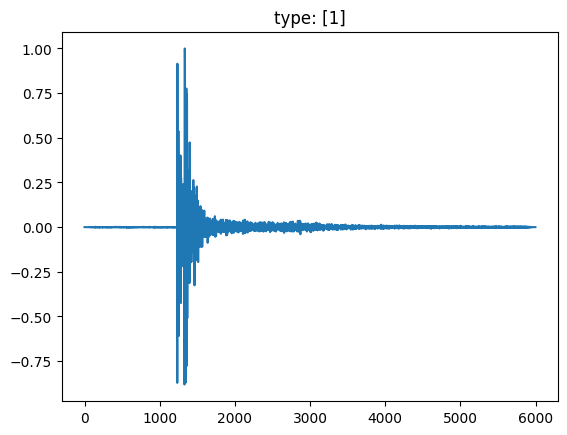

In [4]:
index = 5210
plt.plot(np.arange(waveforms.shape[1]), waveforms[index,:,0])
plt.title(f'type: {event_types[index]}')

In [11]:
model.fit(
    waveforms,
    event_types,
    batch_size=128,
    epochs=2,
    validation_split=0.1,
    verbose=1
)

Epoch 1/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 228s 323ms/step - accuracy: 0.8386 - loss: 0.3748 - val_accuracy: 0.9125 - val_loss: 0.2302
Epoch 2/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 232s 330ms/step - accuracy: 0.8765 - loss: 0.3261 - val_accuracy: 0.9162 - val_loss: 0.2326


In [8]:
print('Preds:')
print(model.predict(waveforms[:10]))
print('True:')
print(event_types[:10])

Preds:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
[[0.10748181]
 [0.99999535]
 [0.99999815]
 [0.08088917]
 [0.02404278]
 [0.99999624]
 [0.5198858 ]
 [0.9999969 ]
 [0.97064286]
 [0.9407139 ]]
True:
[[0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]]
